In [1]:
!pip install xgboost

In [2]:
# Librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_curve, auc, f1_score
from sklearn.model_selection import GridSearchCV

In [3]:
# Cargar archivos
cols = pd.read_csv('C:/Users/gonza/OneDrive/Desktop/Modelos avanzados y Redes Neuronales/Nueva carpeta/feature_names.csv', header=None)[0].tolist()


In [4]:
cleveland = pd.read_csv('C:/Users/gonza/OneDrive/Desktop/Modelos avanzados y Redes Neuronales/Nueva carpeta/processed.cleveland.data', names=cols)
hungarian = pd.read_csv('C:/Users/gonza/OneDrive/Desktop/Modelos avanzados y Redes Neuronales/Nueva carpeta/processed.hungarian.data', names=cols)
switzerland = pd.read_csv('C:/Users/gonza/OneDrive/Desktop/Modelos avanzados y Redes Neuronales/Nueva carpeta/processed.switzerland.data', names=cols)


In [5]:
# Unir datasets
df = pd.concat([cleveland, hungarian, switzerland], ignore_index=True)

In [6]:
# Mostrar dimensiones del DataFrame final
print(f'Dimensiones del dataset unificado: {df.shape}')

# Vista previa de los primeros registros
df.head()

Dimensiones del dataset unificado: (720, 14)


,age,sex,cp,threstbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [7]:
# Reemplazar '?' por NaN
df.replace('?', np.nan, inplace=True)

In [8]:
# Convertir a tipos numéricos
df = df.apply(pd.to_numeric, errors='coerce')

In [9]:
# Re-definir variable objetivo: 0 sin enfermedad, 1 con enfermedad
df['num'] = df['num'].apply(lambda x: 0 if x == 0 else 1)

In [10]:
# Mostrar valores faltantes por columna
missing = df.isnull().sum()
missing_percent = missing / len(df) * 100
print(pd.DataFrame({'missing': missing, 'missing_percent': missing_percent}))

           missing  missing_percent
age              0         0.000000
sex              0         0.000000
cp               0         0.000000
threstbps        3         0.416667
chol            23         3.194444
fbs             83        11.527778
restecg          2         0.277778
thalach          2         0.277778
exang            2         0.277778
oldpeak          6         0.833333
slope          207        28.750000
ca             413        57.361111
thal           320        44.444444
num              0         0.000000


In [11]:
#Descartar atributos con >25% valores ausentes
# Eliminar columnas con más del 25% de valores faltantes
df = df.loc[:, missing_percent < 25]

In [12]:
#Imputación de valores faltantes según clase num
for col in df.columns:
    if df[col].isnull().sum() > 0:
        for clase in [0, 1]:
            mean_val = df[df['num'] == clase][col].mean()
            if df[col].dtype == 'float64' and len(df[col].dropna().unique()) < 10:
                mean_val = round(mean_val)
            df.loc[(df['num'] == clase) & (df[col].isnull()), col] = mean_val


In [13]:
#Variables dummies para variables categóricas con ≥3 categorías
# Detectar variables categóricas (≤10 valores únicos)
categorical_cols = [col for col in df.columns if df[col].nunique() >= 3 and df[col].nunique() <= 10 and col != 'num']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)



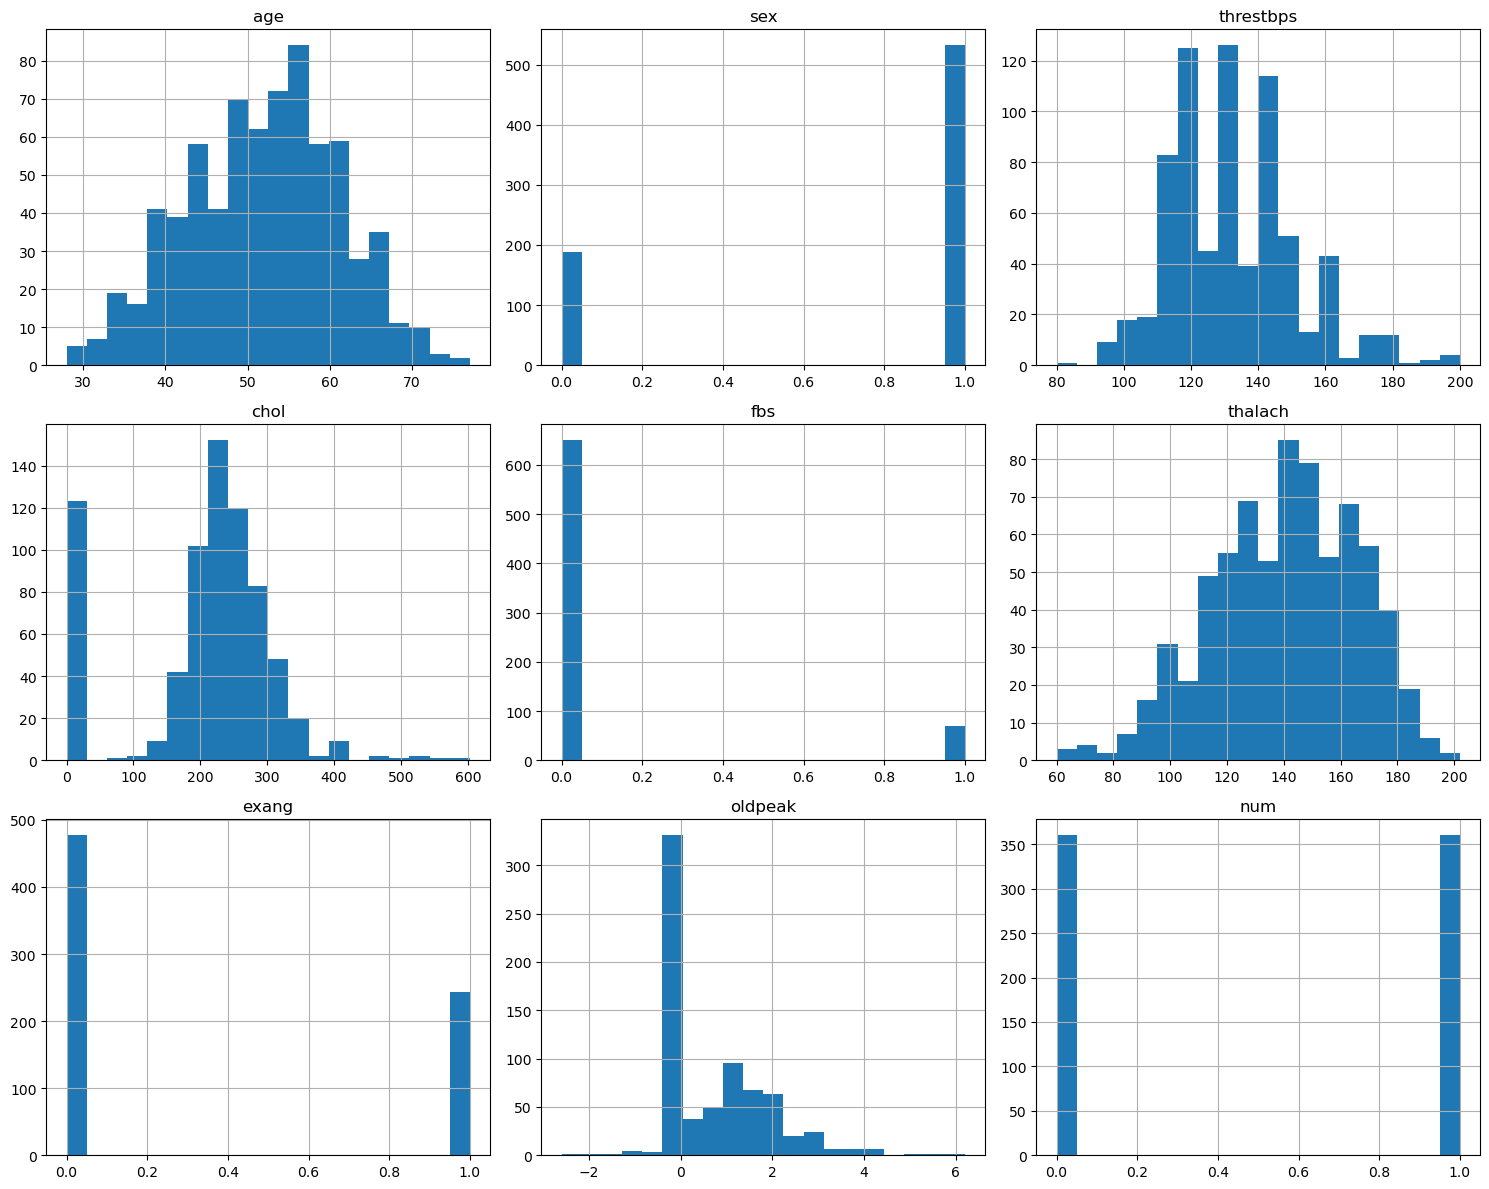

In [14]:
#Análisis descriptivo y visualizaciones
# Histogramas
df.hist(figsize=(15, 12), bins=20)
plt.tight_layout()
plt.show()


In [15]:
#Conclusiones del Análisis Exploratorio
#edad ,distribución simétrica con forma de campana, centrada entre 50-60 años.
#No hay outliers extremos.
#Variable bien distribuida, representativa de pacientes adultos.
#número arábigo(sexo),mayoría de los registros son de sexo masculino (1).
#TrestBPS (presión en reposo),rango habitual entre 100 y 160 mmHg.
#chol (colesterol),Valores típicos entre 150 y 300 mg/dl.
#Thalach (frecuencia cardiaca máxima),distribución normal centrada en 140-160,buen comportamiento. No se observan valores erróneos.


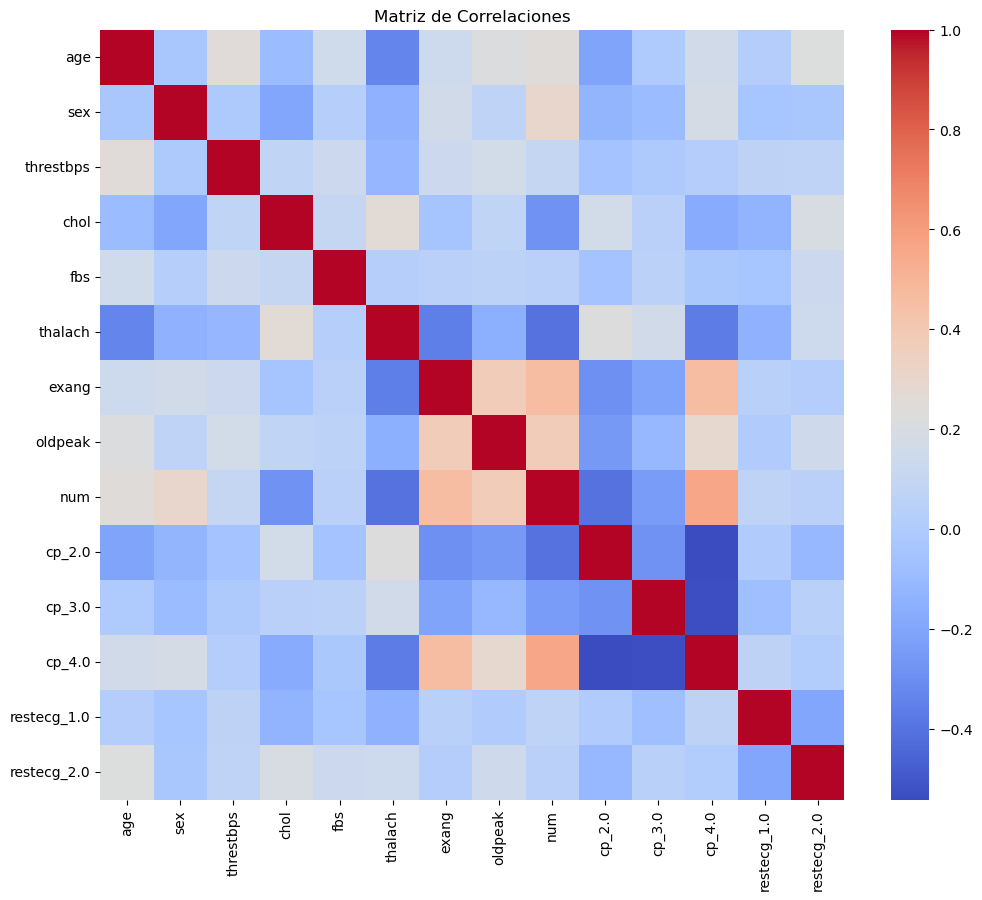

In [16]:
# Correlaciones
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title("Matriz de Correlaciones")
plt.show()

In [17]:
# Conclusiones de la Matriz de Correlaciones
#Variables con mayor correlación con la variable objetivo (num):
#cp_4.0 (dolor torácico asintomático),correlación positiva notable con la presencia de cardiopatía,los pacientes con este tipo de dolor tienen más probabilidad de enfermedad.
#oldpeak (depresión del ST),Correlación positiva con .num,Cuanto mayor es la depresión del ST inducida por ejercicio, mayor probabilidad de cardiopatía.
#exang (angina inducida por ejercicio),también correlaciona positivamente,Aparece como un factor importante en modelos predictivos.
#Thalach (frecuencia cardiaca máxima),Correlación negativa con la enfermedad.A menor frecuencia alcanzada, mayor probabilidad de presencia de enfermedad.

In [18]:
#Separación train/test y entrenamiento de modelos
X = df.drop('num', axis=1)
y = df['num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# AdaBoost
ada = AdaBoostClassifier(random_state=42)
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)
print("AdaBoost:\n", classification_report(y_test, ada_pred))

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
print("Gradient Boosting:\n", classification_report(y_test, gb_pred))

# XGBoost limpio
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
print("XGBoost:\n", classification_report(y_test, xgb_pred))



AdaBoost:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85       122
           1       0.83      0.86      0.85       116

    accuracy                           0.85       238
   macro avg       0.85      0.85      0.85       238
weighted avg       0.85      0.85      0.85       238

Gradient Boosting:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82       122
           1       0.81      0.83      0.82       116

    accuracy                           0.82       238
   macro avg       0.82      0.82      0.82       238
weighted avg       0.82      0.82      0.82       238

XGBoost:
               precision    recall  f1-score   support

           0       0.84      0.83      0.83       122
           1       0.82      0.84      0.83       116

    accuracy                           0.83       238
   macro avg       0.83      0.83      0.83       238
weighted avg       0.83      0.83

In [19]:
#Conclusiones de Desempeño de Modelos
#1. AdaBoost.Puntuación F1: 0,85 (Macro Y ponderado promedio),Precisión y recall equilibradas para ambas clases.Mejor rendimiento global de los tres modelos probados.Recomendado como el mejor modelo base, incluso antes de optimizar hiperparámetros.
#2.número arábigo. XGBoost.Puntuación F1: 0,83.Muy buen rendimiento, apenas por debajo de AdaBoost.Muestra un balance sólido entre precisión y recall.Opción robusta, especialmente si se desea usar técnicas más avanzadas como regularización o importancia de features.
#3. Aumento de gradiente.Puntuación F1: 0.82.Es el modelo con menor desempeño entre los tres.Aun así, su rendimiento es competitivo, pero no supera a AdaBoost ni XGBoost.Puede descartarse si se busca el mejor resultado inmediato sin mayor ajuste.


In [20]:
#Búsqueda de hiperparámetros (modelo con mejor F1)
# Definir grilla de hiperparámetros
param_grid = {
    'n_estimators': np.linspace(20, 200, 15, dtype=int),
    'learning_rate': np.linspace(0.004, 1.0, 40)
}

# Crear instancia del modelo base
ada = AdaBoostClassifier(random_state=42)

# Búsqueda en grilla
grid_search = GridSearchCV(
    ada,
    param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Ajustar al conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar mejores hiperparámetros
print("Mejores parámetros:", grid_search.best_params_)

# Evaluar el mejor modelo encontrado
best_ada = grid_search.best_estimator_
best_ada_pred = best_ada.predict(X_test)

from sklearn.metrics import classification_report
print("Reporte del mejor modelo AdaBoost:\n", classification_report(y_test, best_ada_pred))


Fitting 5 folds for each of 600 candidates, totalling 3000 fits
Mejores parámetros: {'learning_rate': 1.0, 'n_estimators': 71}
Reporte del mejor modelo AdaBoost:
               precision    recall  f1-score   support

           0       0.87      0.82      0.84       122
           1       0.82      0.87      0.85       116

    accuracy                           0.84       238
   macro avg       0.85      0.85      0.84       238
weighted avg       0.85      0.84      0.84       238



In [21]:
#concluciones 
#El modelo mejoró ligeramente respecto al AdaBoost por defecto (de 0.85 a 0.85/0.84 en precisión/recall balanceado).
#Logra detectar correctamente tanto a pacientes con como sin cardiopatía, reduciendo falsos negativos.
#El recall de clase 1 (0.87) indica muy buena capacidad de detección de personas enfermas → ideal en el contexto médico.

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, auc

def plot_roc(model, name):
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')



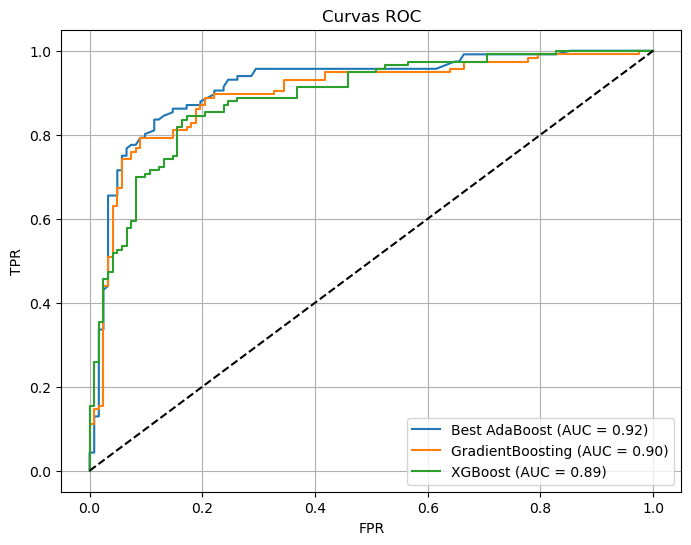

In [23]:
#Curvas ROC
plt.figure(figsize=(8, 6))
plot_roc(best_ada, 'Best AdaBoost')
plot_roc(gb, 'GradientBoosting')
plot_roc(xgb, 'XGBoost')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curvas ROC')
plt.legend()
plt.grid()
plt.show()



In [24]:
#concluciones 
#Todos los modelos tienen AUC > 0.85, lo cual indica un excelente poder discriminativo entre clases (cardiopatía vs. no).
#AdaBoost optimizado se destaca como el mejor modelo no solo en métricas como , sino también en AUC, mostrando:f1-score
#Mejor balance entre TPR (verdaderos positivos) y FPR (falsos positivos).
#Mayor sensibilidad y especificidad general.
#Las curvas están cercanas, pero la de AdaBoost domina consistentemente en casi todo el rango.
#AdaBoost optimizado es el modelo más confiable, robusto y efectivo para detectar pacientes con y sin cardiopatía.
#La curva ROC y su AUC lo respaldan objetivamente como el modelo ideal para implementación en un sistema de diagnóstico asistido por ML.



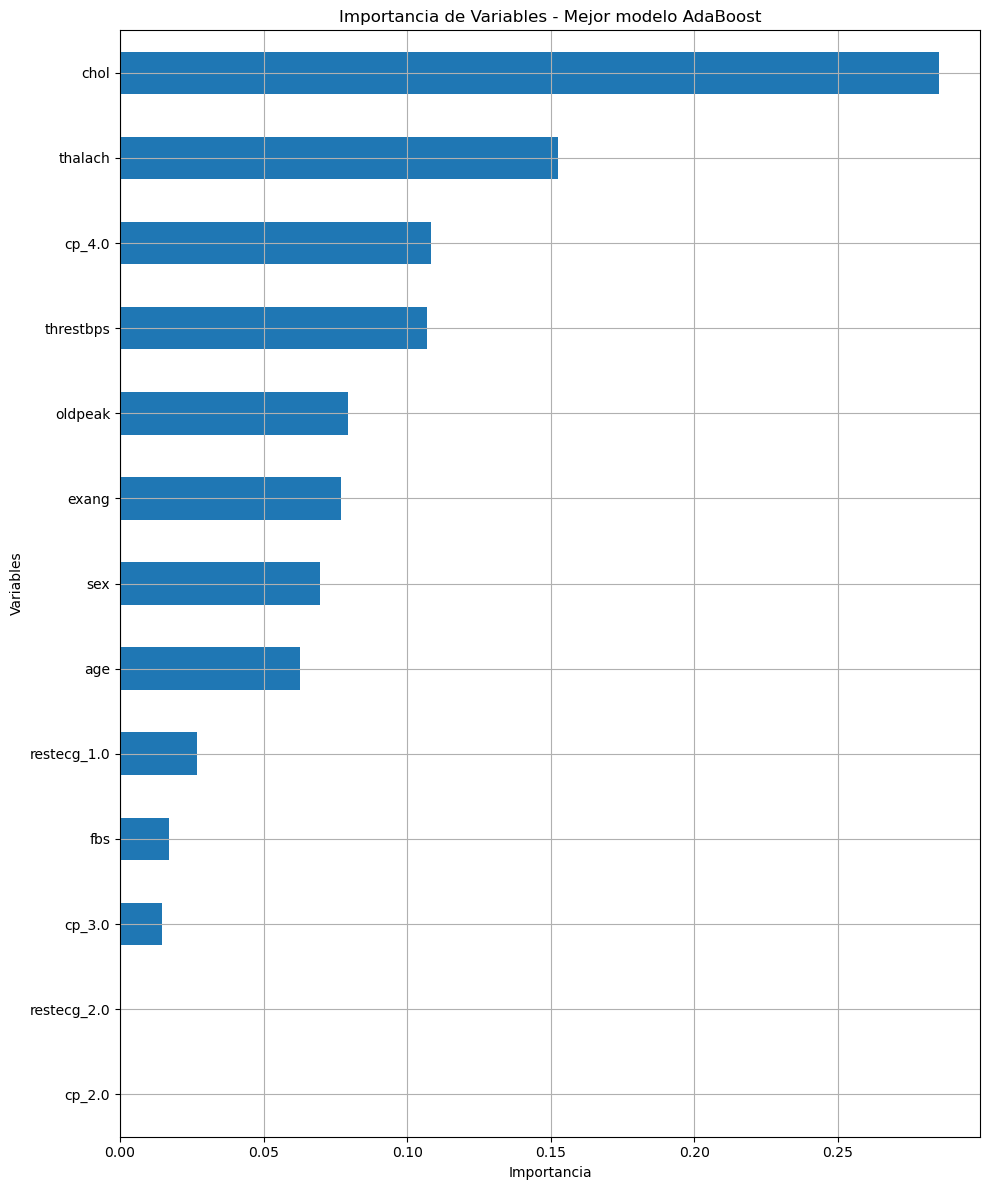

In [25]:
#Importancia de variables (para el mejor modelo)
importances = pd.Series(best_ada.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=True)
# Visualización
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 12))
importances.plot(kind='barh')
plt.title('Importancia de Variables - Mejor modelo AdaBoost')
plt.xlabel('Importancia')
plt.ylabel('Variables')
plt.grid()
plt.tight_layout()
plt.show()


In [26]:
# Conclusiones de Importancia de Variables (AdaBoost):
#chol (colesterol) es la variable más influyente en la predicción de cardiopatía.
#Le siguen: (frecuencia cardiaca máxima), (dolor torácico asintomático), y (presión en reposo).thalachcp_4.0trestbps
